# Pet Recommender System

## Dependencies and imports

In [1]:
from datetime import datetime
import pickle

import pandas as pd
from scipy.spatial.distance import euclidean as scipy_euclidean_distance
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt

from src.encodings import (
    PET_GENDER_ENCODING,
    PET_SIZE_ENCODING,
)
from src.ml_models import (
    encode_non_numeric_features,
    decode_non_numeric_features,
    fill_features_with_means,
    scale_numerical_features,
    unscale_numerical_features,
    impute_realistic_values,
)
from src.vae import VAE

## Dataset preparation

### Load and explore the dataset

In [2]:
dogs_df = pd.read_csv(
    "./data/kiwoko_dogs_data-2025-06-27_12-56-43.csv",
    index_col=0,
)
dogs_df.head()

,name,breed,gender,age,size,province,can_travel,urgent_adoption,needs_vet_care,is_vaccinated,...,is_affectionate,is_hyperactive,is_fearful,is_sociable,is_calm,is_sedentary,description_1,description_2,img_url,info_url
1001,TIRILLAS,Pitbull,Macho,6.0,Grande,Toledo,False,False,False,True,...,True,False,False,True,True,False,A este bombón le encontramos junto a sus tres ...,NaN,https://www.kiwoko.com/servicios/kiwokoadopta/...,https://www.kiwoko.com/servicios/kiwokoadopta/...
1002,LEÓNIDAS,Mestizo,Macho,5.0,Grande,Toledo,False,False,False,True,...,True,False,True,True,True,False,Leónidas te rescatamos de un síndrome de Noe y...,NaN,https://www.kiwoko.com/servicios/kiwokoadopta/...,https://www.kiwoko.com/servicios/kiwokoadopta/...
10026,Rex y Chapi,Mestizo y bodeguero,Macho,5.0,Pequeño,Sevilla,True,False,False,True,...,True,False,False,True,False,False,REX Y CHAPI 💜 La historia de estos dos bombone...,Activos y cariñosos,https://www.kiwoko.com/servicios/kiwokoadopta/...,https://www.kiwoko.com/servicios/kiwokoadopta/...
1004,SUKO,CRUCE LABRADOR,Macho,3.0,Mediano,Madrid,False,False,False,True,...,True,False,False,False,False,False,SUKO es un cruce de labrador nacido en junio d...,NaN,https://www.kiwoko.com/servicios/kiwokoadopta/...,https://www.kiwoko.com/servicios/kiwokoadopta/...
10059,León,Mestizo,Macho,5.0,Mediano,Córdoba,True,True,False,True,...,False,False,True,False,False,False,LEÓN LLEVA 5 AÑOS EN EL REFUGIO 😔💔 Es uno de l...,"Se entrega con chip, pasaporte, vacunas corres...",https://www.kiwoko.com/servicios/kiwokoadopta/...,https://www.kiwoko.com/servicios/kiwokoadopta/...


In [3]:
dogs_df.dtypes

name                   object
breed                  object
gender                 object
age                   float64
size                   object
province               object
can_travel               bool
urgent_adoption          bool
needs_vet_care           bool
is_vaccinated            bool
is_dewormed              bool
is_healthy               bool
is_sterilized            bool
is_identified            bool
has_microchip            bool
has_passport             bool
good_with_children       bool
good_with_cats           bool
good_with_dogs           bool
is_affectionate          bool
is_hyperactive           bool
is_fearful               bool
is_sociable              bool
is_calm                  bool
is_sedentary             bool
description_1          object
description_2          object
img_url                object
info_url               object
dtype: object

In [4]:
dogs_df.describe(include="number")

,age
count,1423.000000
mean,6.473387
std,59.309895
min,0.000000
25%,2.000000
50%,4.000000
75%,7.000000
max,2003.000000


In [5]:
dogs_df.describe(exclude=["number"])

,name,breed,gender,size,province,can_travel,urgent_adoption,needs_vet_care,is_vaccinated,is_dewormed,...,is_affectionate,is_hyperactive,is_fearful,is_sociable,is_calm,is_sedentary,description_1,description_2,img_url,info_url
count,1423,1423,1423,1406,1423,1423,1423,1423,1423,1423,...,1423,1423,1423,1423,1423,1423,1050,1122,1423,1423
unique,1228,425,2,5,33,2,2,2,2,2,...,2,2,2,2,2,2,1014,1037,1419,1423
top,LOLA,Mestizo,Macho,Mediano,Madrid,False,False,False,True,True,...,True,False,False,True,False,False,Perritos en adopción que busca una familia que...,"Se entrega con chip, pasaporte, vacunas corres...",https://www.kiwoko.com/servicios/kiwokoadopta/,https://www.kiwoko.com/servicios/kiwokoadopta/...
freq,6,265,852,760,342,745,1258,1385,1346,1357,...,1075,1353,1281,945,988,1395,17,17,5,1


### Convert categorical features to 'category' type

In [6]:
for feature in ["breed", "size", "province"]:
    dogs_df[feature] = dogs_df[feature].astype("category")

### Drop entries with missing values in key features

In [7]:
dogs_df.isna().sum()

name                    0
breed                   0
gender                  0
age                     0
size                   17
province                0
can_travel              0
urgent_adoption         0
needs_vet_care          0
is_vaccinated           0
is_dewormed             0
is_healthy              0
is_sterilized           0
is_identified           0
has_microchip           0
has_passport            0
good_with_children      0
good_with_cats          0
good_with_dogs          0
is_affectionate         0
is_hyperactive          0
is_fearful              0
is_sociable             0
is_calm                 0
is_sedentary            0
description_1         373
description_2         301
img_url                 0
info_url                0
dtype: int64

In [8]:
no_nan_dogs_df = dogs_df.dropna(subset=["size", "img_url"])
no_nan_dogs_df.isna().sum()

name                    0
breed                   0
gender                  0
age                     0
size                    0
province                0
can_travel              0
urgent_adoption         0
needs_vet_care          0
is_vaccinated           0
is_dewormed             0
is_healthy              0
is_sterilized           0
is_identified           0
has_microchip           0
has_passport            0
good_with_children      0
good_with_cats          0
good_with_dogs          0
is_affectionate         0
is_hyperactive          0
is_fearful              0
is_sociable             0
is_calm                 0
is_sedentary            0
description_1         366
description_2         297
img_url                 0
info_url                0
dtype: int64

### Drop features that are not useful for the recommender system

In [9]:
dogs_filtered_df = no_nan_dogs_df.drop(
    columns=[
        "name",
        "breed",
        "province",  # Temporarily dropped, may be useful but needs some preprocessing
        "can_travel",  # Same as 'province'
        "is_sedentary",
        "description_1",
        "description_2",
        "img_url",
        "info_url",
    ]
)
dogs_filtered_df.head()

,gender,age,size,urgent_adoption,needs_vet_care,is_vaccinated,is_dewormed,is_healthy,is_sterilized,is_identified,has_microchip,has_passport,good_with_children,good_with_cats,good_with_dogs,is_affectionate,is_hyperactive,is_fearful,is_sociable,is_calm
1001,Macho,6.0,Grande,False,False,True,True,True,True,True,True,True,True,False,True,True,False,False,True,True
1002,Macho,5.0,Grande,False,False,True,True,True,True,True,True,True,True,False,True,True,False,True,True,True
10026,Macho,5.0,Pequeño,False,False,True,True,True,True,True,True,True,True,False,False,True,False,False,True,False
1004,Macho,3.0,Mediano,False,False,True,True,True,True,True,True,False,True,False,True,True,False,False,False,False
10059,Macho,5.0,Mediano,True,False,True,True,False,True,True,True,True,True,False,False,False,False,True,False,False


### Drop entries with rare values in key features and undercover cats

In [10]:
dogs_filtered_df = dogs_filtered_df.drop(
    index=[
        2023,
        8706,
        11011,
        11221,
        11334,
        12385,
        12541,
        12780,
        13156,
        13377,
        13378
    ],
    errors="ignore",
)

### Encode categorical and boolean features as integers

In [11]:
dogs_encoded_df = dogs_filtered_df.select_dtypes(include="number")

dogs_encoded_df["is_male"] = dogs_filtered_df["gender"].map(PET_GENDER_ENCODING).astype(int)
dogs_encoded_df["size"] = dogs_filtered_df["size"].map(PET_SIZE_ENCODING).astype(int)

for feature in dogs_filtered_df.select_dtypes(include="boolean").columns:
    dogs_encoded_df[feature] = dogs_filtered_df[feature].astype(int)

dogs_encoded_df.head()

,age,is_male,size,urgent_adoption,needs_vet_care,is_vaccinated,is_dewormed,is_healthy,is_sterilized,is_identified,has_microchip,has_passport,good_with_children,good_with_cats,good_with_dogs,is_affectionate,is_hyperactive,is_fearful,is_sociable,is_calm
1001,6.0,1,3,0,0,1,1,1,1,1,1,1,1,0,1,1,0,0,1,1
1002,5.0,1,3,0,0,1,1,1,1,1,1,1,1,0,1,1,0,1,1,1
10026,5.0,1,1,0,0,1,1,1,1,1,1,1,1,0,0,1,0,0,1,0
1004,3.0,1,2,0,0,1,1,1,1,1,1,0,1,0,1,1,0,0,0,0
10059,5.0,1,2,1,0,1,1,0,1,1,1,1,1,0,0,0,0,1,0,0


In [12]:
dogs_encoded_df.describe()

,age,is_male,size,urgent_adoption,needs_vet_care,is_vaccinated,is_dewormed,is_healthy,is_sterilized,is_identified,has_microchip,has_passport,good_with_children,good_with_cats,good_with_dogs,is_affectionate,is_hyperactive,is_fearful,is_sociable,is_calm
count,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000
mean,4.421455,0.600000,2.287455,0.117563,0.027240,0.946237,0.953405,0.844444,0.820789,0.873118,0.942652,0.754122,0.845878,0.401434,0.701075,0.759140,0.050179,0.101792,0.668100,0.304659
std,3.418580,0.490074,0.763088,0.322205,0.162841,0.225631,0.210845,0.362563,0.383667,0.332960,0.232589,0.430761,0.361195,0.490364,0.457951,0.427759,0.218393,0.302483,0.471064,0.460428
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,7.000000,1.000000,3.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,22.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Visualize the correlation matrix of the scaled dataset

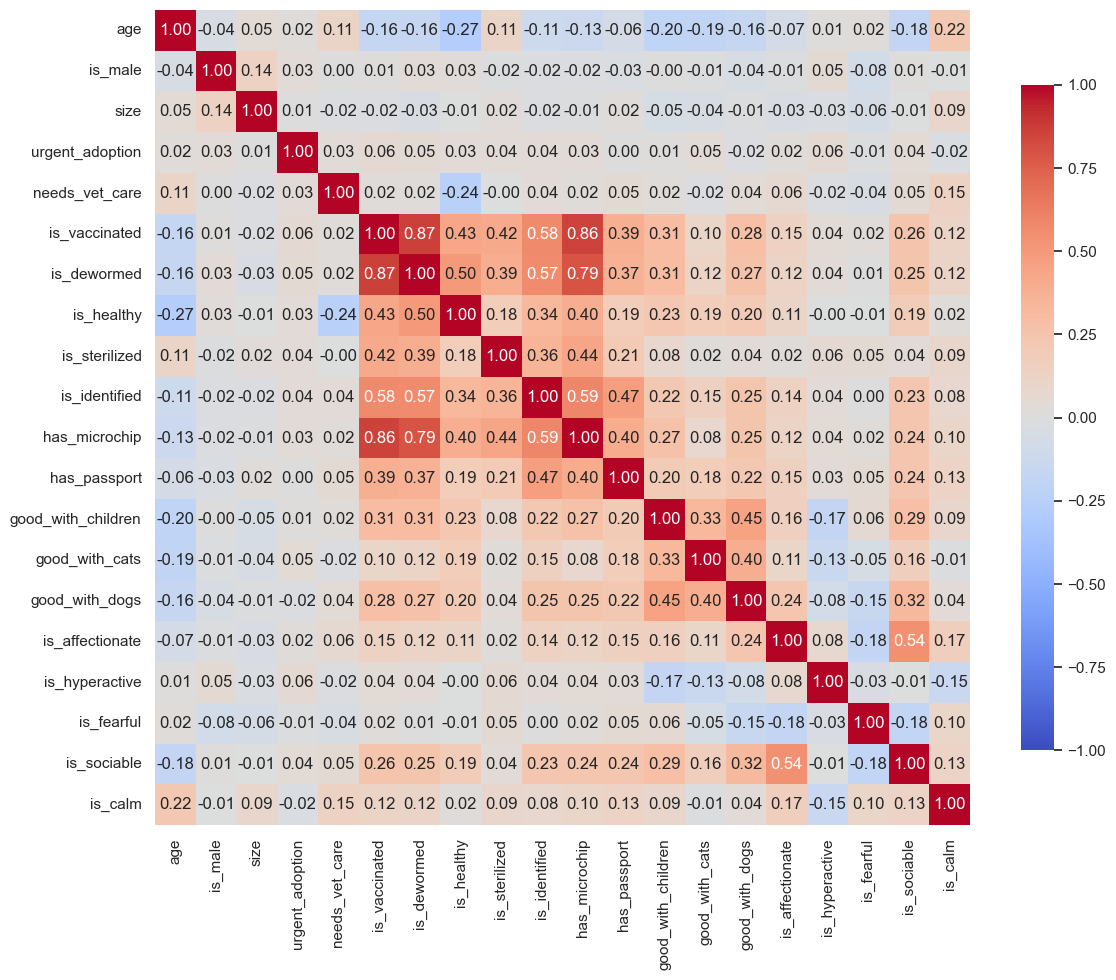

In [13]:
# Set the size of the heatmap
sns.set_theme(rc={"figure.figsize": (12, 10)})
# Create a heatmap to visualize the correlation matrix
sns.heatmap(
    dogs_encoded_df.corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"shrink": 0.8},
    vmin=-1,
    vmax=1,
)
# Save the heatmap as an image
plt.tight_layout()
plt.savefig("./img/dogs_correlation_matrix.png")

### Drop highly correlated features

In [14]:
features_to_drop = [
        "is_dewormed",  # Highly correlated with 'is_vaccinated'
        "is_identified",  # Highly correlated with 'is_vaccinated'
        "has_microchip",  # Highly correlated with 'is_vaccinated'
        "is_affectionate",  # Highly correlated with 'is_sociable'
    ]
dogs_uncorrelated_df = dogs_encoded_df.drop(
    columns=features_to_drop
)
dogs_refiltered_df = dogs_filtered_df.drop(
    columns= features_to_drop
)

### Scale numerical features

In [15]:
scaler_model = MinMaxScaler(
    feature_range=(0, 1),
)

dogs_scaled_df = dogs_uncorrelated_df.copy()
dogs_scaled_df[["age", "size"]] = scaler_model.fit_transform(dogs_scaled_df[["age", "size"]])

dogs_scaled_df.head()

,age,is_male,size,urgent_adoption,needs_vet_care,is_vaccinated,is_healthy,is_sterilized,has_passport,good_with_children,good_with_cats,good_with_dogs,is_hyperactive,is_fearful,is_sociable,is_calm
1001,0.272727,1,0.75,0,0,1,1,1,1,1,0,1,0,0,1,1
1002,0.227273,1,0.75,0,0,1,1,1,1,1,0,1,0,1,1,1
10026,0.227273,1,0.25,0,0,1,1,1,1,1,0,0,0,0,1,0
1004,0.136364,1,0.50,0,0,1,1,1,0,1,0,1,0,0,0,0
10059,0.227273,1,0.50,1,0,1,0,1,1,1,0,0,0,1,0,0


In [16]:
dogs_scaled_df.describe()

,age,is_male,size,urgent_adoption,needs_vet_care,is_vaccinated,is_healthy,is_sterilized,has_passport,good_with_children,good_with_cats,good_with_dogs,is_hyperactive,is_fearful,is_sociable,is_calm
count,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000
mean,0.200975,0.600000,0.571864,0.117563,0.027240,0.946237,0.844444,0.820789,0.754122,0.845878,0.401434,0.701075,0.050179,0.101792,0.668100,0.304659
std,0.155390,0.490074,0.190772,0.322205,0.162841,0.225631,0.362563,0.383667,0.430761,0.361195,0.490364,0.457951,0.218393,0.302483,0.471064,0.460428
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.090909,0.000000,0.500000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.181818,1.000000,0.500000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,0.318182,1.000000,0.750000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Calculate the dataset means for user input preprocessing at inference time

In [17]:
dogs_features_means = dogs_scaled_df.mean()
dogs_features_means

age                   0.200975
is_male               0.600000
size                  0.571864
urgent_adoption       0.117563
needs_vet_care        0.027240
is_vaccinated         0.946237
is_healthy            0.844444
is_sterilized         0.820789
has_passport          0.754122
good_with_children    0.845878
good_with_cats        0.401434
good_with_dogs        0.701075
is_hyperactive        0.050179
is_fearful            0.101792
is_sociable           0.668100
is_calm               0.304659
dtype: float64

## Models definition and training

### Variational Autoencoder (VAE) model definition for missing data imputation

In [18]:
# Set the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
# Prepare data for training
dogs_tensor = torch.tensor(dogs_scaled_df.to_numpy(), dtype=torch.float32, device=device)
dogs_dataset = TensorDataset(dogs_tensor)
dogs_loader = DataLoader(dogs_dataset, batch_size=32, shuffle=True, num_workers=0)

In [20]:
# Initialize the VAE model
vae_model = VAE(input_dim=dogs_tensor.shape[1], latent_dim=8, hidden_dim=16)
# Move the model to the device
vae_model.to(device)

VAE(
  (fc1): Linear(in_features=16, out_features=16, bias=True)
  (fc_mu): Linear(in_features=16, out_features=8, bias=True)
  (fc_log_var): Linear(in_features=16, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=16, bias=True)
)

In [21]:
# Train the VAE model
history = vae_model.train_vae(dogs_loader, num_epochs=25, learning_rate=1e-3)

Epoch 1, Loss: 7.0327
Epoch 2, Loss: 4.3480
Epoch 3, Loss: 3.4046
Epoch 4, Loss: 3.0252
Epoch 5, Loss: 2.7077
Epoch 6, Loss: 2.4839
Epoch 7, Loss: 2.3597
Epoch 8, Loss: 2.2930
Epoch 9, Loss: 2.2840
Epoch 10, Loss: 2.2405
Epoch 11, Loss: 2.2080
Epoch 12, Loss: 2.2151
Epoch 13, Loss: 2.1930
Epoch 14, Loss: 2.1794
Epoch 15, Loss: 2.1611
Epoch 16, Loss: 2.1709
Epoch 17, Loss: 2.1485
Epoch 18, Loss: 2.1544
Epoch 19, Loss: 2.1475
Epoch 20, Loss: 2.1425
Epoch 21, Loss: 2.1424
Epoch 22, Loss: 2.1283
Epoch 23, Loss: 2.1386
Epoch 24, Loss: 2.1402
Epoch 25, Loss: 2.1194


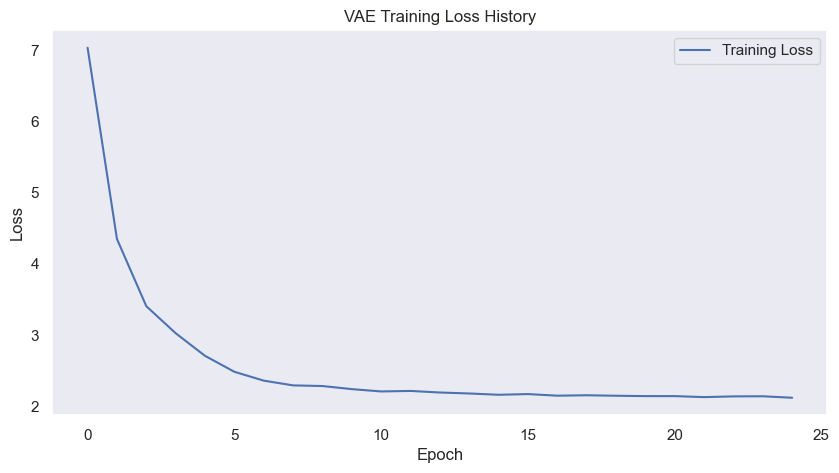

In [22]:
# Plot the training loss history
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(history.keys(), history.values(), label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training Loss History")
plt.legend()
plt.grid()
plt.savefig("./img/vae_training_loss_history.png")
plt.show()

In [23]:
# Save the trained VAE model
with open(f"./models/vae_dog_adoption-{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.pkl", "wb") as model_file:
    pickle.dump(vae_model, model_file)

### Nearest Neighbors model definition for the recommender system

In [24]:
# Split the dataset into training and testing subsets
dogs_train_df, dogs_test_df = train_test_split(dogs_scaled_df, test_size=0.2, random_state=42, shuffle=True)
dogs_train_df.shape, dogs_test_df.shape

((1116, 16), (279, 16))

In [25]:
feature_weights = {
    "is_male": 1,
    "size": 0.7,
    "age": 3,
    "can_travel": 5,
    "urgent_adoption": 5,
    "is_vaccinated": 0.2,
    "is_healthy": 0.9,
    "is_sterilized": 0.2,
    "has_passport": 0.2,
    "good_with_children": 0.7,
    "good_with_cats": 0.8,
    "good_with_dogs": 0.8,
    "is_hyperactive": 0.7,
    "is_fearful": 0.6,
    "is_sociable": 0.7,
    "is_calm": 0.6,
    "needs_vet_care": 0.9,
    "is_sedentary": None
}

In [26]:
# Define and train the Nearest Neighbors model
knn_model = NearestNeighbors(
    n_neighbors=2,
    algorithm="auto",
    metric=scipy_euclidean_distance,
    metric_params={
        "w": [
            feature_weights[feature]
            for feature in dogs_train_df.columns
        ]
    }
)
knn_model.fit(dogs_train_df)

NearestNeighbors(metric=<function euclidean at 0x7fccdfebe3e0>,
                 metric_params={'w': [3, 1, 0.7, 5, 0.9, 0.2, 0.9, 0.2, 0.2,
                                      0.7, 0.8, 0.8, 0.7, 0.6, 0.7, 0.6]},
                 n_neighbors=2)

In [27]:
# Save the trained Nearest Neighbors model
with open(f"./models/knn_dog_adoption-{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.pkl", "wb") as model_file:
    pickle.dump(knn_model, model_file)

## System usage examples

### Case 1: Client is searching a dog with all wanted features provided

In [28]:
# Extract a random dog sample from the test dataset
dog_case_1 = dogs_test_df.sample(1)
print("Current client is searching a dog with the following features:")
print(dogs_filtered_df.loc[dog_case_1.index[0]])

Current client is searching a dog with the following features:
gender                  Macho
age                       4.0
size                  Gigante
urgent_adoption         False
needs_vet_care          False
is_vaccinated            True
is_dewormed              True
is_healthy               True
is_sterilized            True
is_identified            True
has_microchip            True
has_passport            False
good_with_children       True
good_with_cats          False
good_with_dogs           True
is_affectionate         False
is_hyperactive          False
is_fearful              False
is_sociable             False
is_calm                 False
Name: 496, dtype: object


In [29]:
# Get the nearest neighbors for the dog sample
diffs, nearest_dog_ids_case_1 = knn_model.kneighbors(dog_case_1, n_neighbors=5, return_distance=True)
print(diffs)
print(nearest_dog_ids_case_1)

[[0.         0.31549188 0.31549188 0.37805232 0.41833001]]
[[142 512 348 761 744]]


In [30]:
print("The most similar dog currently available for adoption has the following features:")
print(dogs_df.loc[dogs_train_df.iloc[nearest_dog_ids_case_1[0][0]].name])
print(dogs_df.loc[dogs_train_df.iloc[nearest_dog_ids_case_1[0][0]].name]["info_url"])

The most similar dog currently available for adoption has the following features:
name                                                              NERON
breed                                                            MASTIN
gender                                                            Macho
age                                                                 4.0
size                                                            Gigante
province                                                         Madrid
can_travel                                                        False
urgent_adoption                                                   False
needs_vet_care                                                    False
is_vaccinated                                                      True
is_dewormed                                                        True
is_healthy                                                         True
is_sterilized                                         

In [31]:
print("Another similar dog currently available for adoption has the following features:")
print(dogs_df.loc[dogs_train_df.iloc[nearest_dog_ids_case_1[0][1]].name])
print(dogs_df.loc[dogs_train_df.iloc[nearest_dog_ids_case_1[0][1]].name]["info_url"])

Another similar dog currently available for adoption has the following features:
name                                                             Roscón
breed                                                           Mestizo
gender                                                            Macho
age                                                                 1.0
size                                                             Grande
province                                                         Madrid
can_travel                                                         True
urgent_adoption                                                   False
needs_vet_care                                                    False
is_vaccinated                                                      True
is_dewormed                                                        True
is_healthy                                                         True
is_sterilized                                          

### Case 2: Client is searching a dog with some wanted features provided and some missing

In [32]:
# Create a new desired dog sample with some missing features
dog_case_2 = pd.Series({
    "urgent_adoption": True,
    "gender": "Macho",
    "age": 3,
    "size": "Mediano",
    "can_travel": True,
})

In [33]:
# Drop NaN values from the input
filtered_client_input = dog_case_2.dropna()

# Encode categorical and boolean features
encoded_client_input = encode_non_numeric_features(filtered_client_input, dogs_filtered_df)
encoded_client_input

KeyError: 'can_travel'

In [74]:
# Fill missing values with the mean of each feature
mean_filled_client_input = fill_features_with_means(encoded_client_input, dogs_features_means)
print(mean_filled_client_input)

age                   3.000000
is_male               1.000000
size                  2.000000
can_travel            1.000000
urgent_adoption       1.000000
needs_vet_care        0.027240
is_vaccinated         0.946237
is_healthy            0.844444
is_sterilized         0.820789
has_passport          0.754122
good_with_children    0.845878
good_with_cats        0.401434
good_with_dogs        0.701075
is_hyperactive        0.050179
is_fearful            0.101792
is_sociable           0.668100
is_calm               0.304659
dtype: float64


In [75]:
# Scale the numerical features
scaled_client_input = scale_numerical_features(mean_filled_client_input, scaler_model)
print(scaled_client_input)

age                   0.136364
is_male               1.000000
size                  0.500000
can_travel            1.000000
urgent_adoption       1.000000
needs_vet_care        0.027240
is_vaccinated         0.946237
is_healthy            0.844444
is_sterilized         0.820789
has_passport          0.754122
good_with_children    0.845878
good_with_cats        0.401434
good_with_dogs        0.701075
is_hyperactive        0.050179
is_fearful            0.101792
is_sociable           0.668100
is_calm               0.304659
dtype: float64


In [76]:
# Check if there hava been any features that were not provided by the user, if there
#  is any, get coherent values for those features from the pre-trained VAE model
complete_client_input = (
    impute_realistic_values(scaled_client_input, encoded_client_input.index, vae_model)
    if any(dog_case_2.isna())
    else scaled_client_input
)
print(complete_client_input)

age                   0.136364
is_male               1.000000
size                  0.500000
can_travel            1.000000
urgent_adoption       1.000000
needs_vet_care        0.027240
is_vaccinated         0.946237
is_healthy            0.844444
is_sterilized         0.820789
has_passport          0.754122
good_with_children    0.845878
good_with_cats        0.401434
good_with_dogs        0.701075
is_hyperactive        0.050179
is_fearful            0.101792
is_sociable           0.668100
is_calm               0.304659
dtype: float64


In [77]:
# Decode and unscale the VAE completed client input after preprocessing only for visualization
print(decode_non_numeric_features(unscale_numerical_features(complete_client_input, scaler_model), dogs_refiltered_df))

age                       3.0
gender                  Macho
size                  Mediano
can_travel               True
urgent_adoption          True
needs_vet_care          False
is_vaccinated            True
is_healthy               True
is_sterilized            True
has_passport             True
good_with_children       True
good_with_cats          False
good_with_dogs           True
is_hyperactive          False
is_fearful              False
is_sociable              True
is_calm                 False
dtype: object


In [78]:
# Reshape the input to match the expected format for the KNN model
input_data = pd.DataFrame(
    complete_client_input.values.reshape(1, -1),
    columns=complete_client_input.index,
)

# Find the nearest neighbors for the filled client input
diffs, nearest_dog_ids_case_2 = knn_model.kneighbors(input_data, n_neighbors=5, return_distance=True)
print(diffs)
print(nearest_dog_ids_case_1)

[[0.63682671 0.65126285 0.68402726 0.75050273 0.77404347]]
[[ 965  484 1025   12  846]]


In [79]:
print("The most similar dog currently available for adoption has the following features:")
print(dogs_df.iloc[nearest_dog_ids_case_2[0][0]])

The most similar dog currently available for adoption has the following features:
name                                                               Sara
breed                                                           Mestiza
gender                                                           Hembra
age                                                                 8.0
size                                                            Mediano
province                                                         Madrid
can_travel                                                        False
urgent_adoption                                                   False
needs_vet_care                                                     True
is_vaccinated                                                     False
is_dewormed                                                       False
is_healthy                                                        False
is_sterilized                                         

In [80]:
print("Another similar dog currently available for adoption has the following features:")
print(dogs_df.iloc[nearest_dog_ids_case_2[0][1]])

Another similar dog currently available for adoption has the following features:
name                                                              Teddy
breed                                                           Mestiza
gender                                                            Macho
age                                                                11.0
size                                                             Grande
province                                                       Valencia
can_travel                                                         True
urgent_adoption                                                   False
needs_vet_care                                                    False
is_vaccinated                                                      True
is_dewormed                                                        True
is_healthy                                                        False
is_sterilized                                          